In [1]:
import os
import time
import numpy as np
import random
import sys
import netCDF4 as ncdf

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.ticker import LongitudeFormatter , LatitudeFormatter

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

In [2]:
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
expname = ["SPCAM", "NNCAM", "NNCAM(PhyC)", "CAM5"]#, "new50_rh1d"]
caserealname = ["spcam.baseline", "2021_11_15", "baseline_nn_rh", "2022_11_10"]
# caserealname = ["spcam.baseline", "2021_11_15", "crash1_rh_rerun0612", "2022_11_10"]

spcam_path    = "/temp_share/nncam-cases/nncam-diag_spcam/spcam.baseline/atm/hist/"
nncam_path    = "/temp_share/nncam-cases/nncam-couple/2021_11_15/atm/hist/"
# nncamrh_path  = "/temp_share/stabilities.analysis/hist.plot/hist.nc-data/case1_6years/"
nncamrh_path  = "/temp_share/nncam-cases/neuroGCM/baseline_nn_rh/atm/hist/"
cam5_path     = "/temp_share/nncam-cases/nncam-diag_cam5/2022_11_10/atm/hist/"

filepath = [spcam_path, nncam_path, nncamrh_path, cam5_path]

print(filepath)
          
# savepath='{}.plot'.format(expname)
# if os.path.isdir(savepath) is False:
#     os.mkdir(savepath)  

['/temp_share/nncam-cases/nncam-diag_spcam/spcam.baseline/atm/hist/', '/temp_share/nncam-cases/nncam-couple/2021_11_15/atm/hist/', '/temp_share/nncam-cases/neuroGCM/baseline_nn_rh/atm/hist/', '/temp_share/nncam-cases/nncam-diag_cam5/2022_11_10/atm/hist/']


In [4]:
lenth = 6 * 12

# yearbuff  = ['0002', '0003', '0004', '0005', '0006']#, 2002]#,2003]
yearbuff  = [1998, 1999, 2000, 2001, 2002, 2003]
monthbuff = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
_2mT      = np.zeros((len(expname),lenth,96,144))

# 读取数据
ii=0

winter_months = []
summer_months = []

for iyear in yearbuff:
    for imonth in monthbuff:
        if imonth in [12, 1, 2]:
            w_i = (iyear - 1998) * 12 + (imonth - 1)
            print(w_i)
            winter_months.append(w_i)

        if imonth in [6, 7, 8]:
            s_i = (iyear - 1998) * 12 + (imonth - 1)
            print(s_i)
            summer_months.append(s_i)
        
        for icase, casename in enumerate(caserealname):
                
            filename = "{}.cam.h0.{:04d}-{:02d}.nc".format(casename,iyear, imonth)
            data     = ncdf.Dataset(os.path.join(filepath[icase], filename),'r')
            _2mT[icase, ii,:,:] = data['TREFHT'][0,:,:]*24*3600*1000

        ii+=1

        print("{:04d}-{:02d}".format(iyear, imonth))

for i in [0, 1, 71]:
    winter_months.remove(i)

for i in [5, 6, 7]:
    summer_months.remove(i)

0
1998-01
1
1998-02
1998-03
1998-04
1998-05
5
1998-06
6
1998-07
7
1998-08
1998-09
1998-10
1998-11
11
1998-12
12
1999-01
13
1999-02
1999-03
1999-04
1999-05
17
1999-06
18
1999-07
19
1999-08
1999-09
1999-10
1999-11
23
1999-12
24
2000-01
25
2000-02
2000-03
2000-04
2000-05
29
2000-06
30
2000-07
31
2000-08
2000-09
2000-10
2000-11
35
2000-12
36
2001-01
37
2001-02
2001-03
2001-04
2001-05
41
2001-06
42
2001-07
43
2001-08
2001-09
2001-10
2001-11
47
2001-12
48
2002-01
49
2002-02
2002-03
2002-04
2002-05
53
2002-06
54
2002-07
55
2002-08
2002-09
2002-10
2002-11
59
2002-12
60
2003-01
61
2003-02
2003-03
2003-04
2003-05
65
2003-06
66
2003-07
67
2003-08
2003-09
2003-10
2003-11
71
2003-12


In [5]:
DJF_2mT = np.mean(_2mT[:, winter_months, :, :], axis=1)
JJA_2mT = np.mean(_2mT[:, summer_months, :, :], axis=1)
ANN_2mT = _2mT.mean(axis=1)

NameError: name 'ANN_precip' is not defined

In [6]:
print(DJF_2mT.shape)
print(JJA_2mT.shape)
print(ANN_2mT.shape)

(4, 96, 144)
(4, 96, 144)
(4, 96, 144)


In [7]:
ANN_2mT[0].mean()

23963336170.631687

In [21]:
def plot_single_precip(fig, gs, subfig_index, precip, color_interval, title_font, expname, mean, rmse, spcam_flag):#:subtitle):
    
    jlon = np.linspace(0,357.5,144)
    jlat = np.linspace(-90,90,96)
    prj = ccrs.PlateCarree(central_longitude = 0)

    axs = fig.add_subplot(gs[i, j], projection = ccrs.Robinson(central_longitude=180))
  # axs = fig.add_subplot(projection = ccrs.Robinson(central_longitude=180)) 
    axs.add_feature(cfeat.COASTLINE, edgecolor = '#333333', linewidth=0.5)
  # cs0 = axs.contourf(jlon, jlat, precip, np.linspace(plotrange[0], plotrange[1], 21), cmap = plt.cm.coolwarm, extend='both', transform = prj)
  # cs0 = axs.contourf(jlon, jlat, precip, color_interval, cmap = plt.cm.coolwarm, extend='both', transform = prj)
    cs0 = axs.contourf(jlon, jlat, precip, color_interval, cmap = plt.cm.RdBu_r, extend='both', transform = prj)
    axs.tick_params(labelsize = 7)

    title_left = "{}) {}".format(chr(subfig_index + 96), expname)
#     title_right = "mean = {:.3f} rmse = {:.3f}".format(mean, rmse)
    if spcam_flag:
        title_right = "mean = {:.3f}".format(mean)
    else:
        title_right = "mean = {:.3f} rmse = {:.3f}".format(mean, rmse)
        
    axs.set_title(title_left,  title_font, loc = "left")
    axs.set_title(title_right, title_font, loc = "right")
    
    return {'fig': fig, 'axs': axs, "cs0": cs0} #, 'cax': cax}

In [8]:
def subtitle_val(diag_cp, target_cp):
    
    mean = np.mean(diag_cp)
    rmse = np.sqrt(mean_squared_error(diag_cp, target_cp))
       
    return mean, rmse

In [9]:
# # 创建一个新的图形和一个 3x2 的网格
# fig = plt.figure(figsize=(8, 4))
# gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05], figure=fig)
# gs.update(wspace=0.3, hspace=0.3)
# color_interval = [0, 0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17] # 降水的非等距 color bar
# font = {'weight':'normal','size':7.75}

# # 在每个格子上添加一个子图
# for i in range(2):
#     for j in range(2):
#         plot = plot_single_precip(fig, gs, i*2+j+1, precip[i*2+j].mean(axis=0), color_interval, font, expname[i*2+j], 0.233, 1.233, spcam_flag)#, [0,357.5,-90,90])

# cax = fig.add_subplot(gs[0:2, -1])
# fig.colorbar(plot['cs0'], cax=cax, orientation='vertical', shrink = 0.7, pad=0.02)

# plt.tight_layout()
# plt.savefig('ann-multi_precipitation_plot.pdf')

In [10]:
ANN_precip[0].shape

(96, 144)

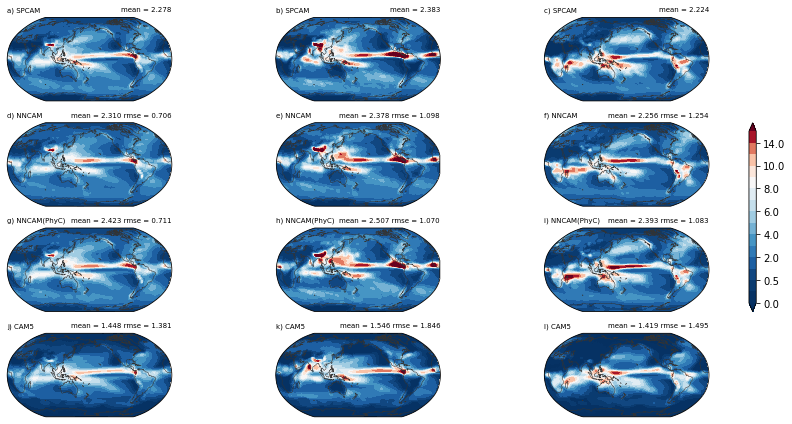

In [23]:
# 创建一个新的图形和一个 3x2 的网格
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 0.025], figure=fig)
# gs.update(wspace=0.05)#, hspace=0.25)
color_interval = [0, 0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17] # 降水的非等距 color bar
font = {'weight':'normal','size':7}
# font = {'weight':'normal','size':7.75}
spcam_flag = False

# 在每个格子上添加一个子图
for i in range(4):
    for j in range(3):
        
        if j == 0:
            temp_cp  = ANN_precip[i]
            spcam_cp = ANN_precip[0]
        elif j == 1:
            temp_cp  = JJA_precip[i]
            spcam_cp = JJA_precip[0]
        else:
            temp_cp  = DJF_precip[i]
            spcam_cp = DJF_precip[0]
        
        if i == 0:
            spcam_flag = True
        
        mean = temp_cp.mean()
        rmse = np.sqrt(mean_squared_error(temp_cp, spcam_cp))

        plot = plot_single_precip(fig, gs, i*3+j+1, temp_cp, color_interval, font, expname[i], mean, rmse, spcam_flag)#, [0,357.5,-90,90])
#         plot = plot_single_precip(fig, gs, i*3+j+1, temp_cp, color_interval, font, expname[i], mean, rmse)#, [0,357.5,-90,90])

        spcam_flag = False
    
cax = fig.add_subplot(gs[1:3, -1])
fig.colorbar(plot['cs0'], cax=cax, orientation='vertical', shrink = 0.7, pad=0.02)

plt.subplots_adjust(top=0.9)
# plt.tight_layout()
plt.tight_layout(w_pad=0.05)
plt.savefig('3x4-multi_precipitation_plot.pdf')

In [16]:
def plot_single_precip_diff(fig, gs, subfig_index, precip, title_font, expname, bias, spcam_flag):#:subtitle):
    
    jlon = np.linspace(0,357.5,144)
    jlat = np.linspace(-90,90,96)
    prj = ccrs.PlateCarree(central_longitude = 0)

    axs = fig.add_subplot(gs[i, j], projection = ccrs.Robinson(central_longitude=180))
  # axs = fig.add_subplot(projection = ccrs.Robinson(central_longitude=180)) 
    axs.add_feature(cfeat.COASTLINE, edgecolor = '#333333', linewidth=0.5)
  # cs0 = axs.contourf(jlon, jlat, precip, np.linspace(plotrange[0], plotrange[1], 21), cmap =plt.cm.coolwarm, extend='both', transform = prj)
    cs0 = axs.contourf(jlon, jlat, precip, np.linspace(-10, 10, 21), cmap =plt.cm.coolwarm, extend='both', transform = prj)
    axs.tick_params(labelsize = 7)

    title_left = "{}) {}".format(chr(subfig_index + 96), expname)
    title_right = "bias = {:.3f}".format(bias)
#     if spcam_flag:
#         title_right = "mean = {:.3f}".format(mean)
#     else:
#         title_right = "mean = {:.3f} rmse = {:.3f}".format(mean, rmse)
        
    axs.set_title(title_left,  title_font, loc = "left")
    axs.set_title(title_right, title_font, loc = "right")
    
    return {'fig': fig, 'axs': axs, "cs0": cs0} #, 'cax': cax}

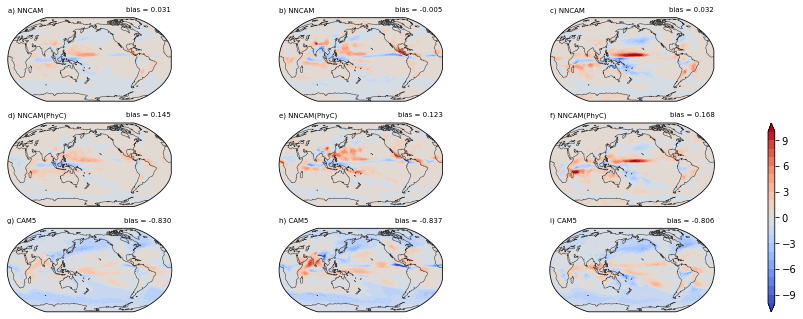

In [24]:
# 创建一个新的图形和一个 3x2 的网格
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 0.025], figure=fig)
# gs.update(wspace=0.05)#, hspace=0.25)
# color_interval = [-10, -9, -8, -7, -6, -5, -4, -1, -2, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # 降水的非等距 color bar
font = {'weight':'normal','size':7}
# font = {'weight':'normal','size':7.75}
spcam_flag = False

# 在每个格子上添加一个子图
for i in range(3):
    for j in range(3):
        
        if j == 0:
            temp_cp  = ANN_precip[i+1]
            spcam_cp = ANN_precip[0]
        elif j == 1:
            temp_cp  = JJA_precip[i+1]
            spcam_cp = JJA_precip[0]
        else:
            temp_cp  = DJF_precip[i+1]
            spcam_cp = DJF_precip[0]
        
        if i == 0:
            spcam_flag = True
        
        diff_cp = temp_cp - spcam_cp
        bias    = diff_cp.mean()
      # mean = temp_cp.mean()
      # rmse = np.sqrt(mean_squared_error(temp_cp, spcam_cp))

        plot = plot_single_precip_diff(fig, gs, i*3+j+1, diff_cp, font, expname[i+1], bias, spcam_flag)#, [0,357.5,-90,90])
#         plot = plot_single_precip(fig, gs, i*3+j+1, temp_cp, color_interval, font, expname[i], mean, rmse)#, [0,357.5,-90,90])

        spcam_flag = False
    
cax = fig.add_subplot(gs[1:3, -1])
fig.colorbar(plot['cs0'], cax=cax, orientation='vertical', shrink = 0.7, pad=0.02)

plt.subplots_adjust(top=0.9)
# plt.tight_layout()
plt.tight_layout(w_pad=0.05)
plt.savefig('3x4-multi_precipitation_diff.pdf')